In [2]:
import tensorflow as tf

import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_dir ="/content/gdrive/MyDrive/dataset/photos"
   

In [6]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir                             #We converted our directory to windows pathlib directory

PosixPath('/content/gdrive/MyDrive/dataset/photos')

In [7]:
import pathlib                        #We have used pathlib in data directory so that we are able to use glob and you can 
data_dir = pathlib.Path(data_dir)      #already see the advantages of glob, when we use pathlib we see tha it is a Windows path 
data_dir                             #We converted our directory to windows pathlib directory

PosixPath('/content/gdrive/MyDrive/dataset/photos')

In [8]:
alzheimer_images_dict = {                                    #here we have created a dictionary, if we do 
    'mild': list(data_dir.glob('MildDemented/*')),           #alzheimer_images_dict[MildDemented] we get all paths of 
    'moderate': list(data_dir.glob('ModerateDemented/*')),   #milddemented
    'no': list(data_dir.glob('NonDemented/*')),
    'verymild': list(data_dir.glob('VeryMildDemented/*')),
  
}

In [9]:
alzheimer_labels_dict = {   #here I am assigning labels to each of the  classes
    'mild': 0,
    'moderate': 1,
    'no': 2,
    'verymild': 3,
    
}

In [10]:
X, y = [], []

for alzheimer_name, images in alzheimer_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(alzheimer_labels_dict[alzheimer_name])
print(X[0].shape)  

(224, 224, 3)


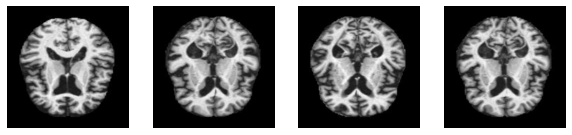

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [13]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [14]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (4288, 224, 224, 3)
X_test Shape:  (2112, 224, 224, 3)
y_train Shape:  (4288, 4)
y_test Shape:  (2112, 4)


In [15]:
 from keras.applications.nasnet import NASNetMobile



img_rows, img_cols = 224, 224 


pretained_model =tf.keras.applications.nasnet.NASNetMobile(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))  #where ever false is there means that they are not going  to trained 
                                                        #again as they are alredy being trained
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in pretained_model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(pretained_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

20004864/19993432 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Activation False
8 ZeroPadding2D False
9 ZeroPadding2D False
10 SeparableConv2D False
11 SeparableConv2D False
12 BatchNormalization False
13 BatchNormalization False
14 Activation False
15 Activation False
16 SeparableConv2D False
17 SeparableConv2D False
18 Activation False
19 BatchNormalization False
20 BatchNormalization False
21 ZeroPadding2D False
22 Activation False
23 Add False
24 SeparableConv2D False
25 ZeroPadding2D False
26 Activation False
27 BatchNormalization False
28 SeparableConv2D False
29 SeparableConv2D False
30 Activation False
31 BatchNormalization False
32 BatchNormalization False
33 ZeroPadding2D False
34 SeparableConv2D False
35 Activation False
36 Activation False
37 MaxPooling2D False
38 BatchNormalization False
39 SeparableConv2D False
40 SeparableConv2D

In [16]:
num_classes = 4
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""                      #here I adding extra additional layers that will be helpful 
                                                              #in my program.
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(pretained_model, num_classes)   #here you can see I am passing vgg and number of classes to the lw func and lw bottom model
                                 #will be vgg
model = Model(inputs = pretained_model.input, outputs = FC_Head)


In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             
                                )                                                             

In [19]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [20]:
history = model.fit(X_train,y_train,
                    epochs=100, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/100
134/134 [==============================] - 35s 111ms/step - loss: 1.1522 - accuracy: 0.5292 - val_loss: 0.9300 - val_accuracy: 0.5360
Epoch 2/100
134/134 [==============================] - 11s 86ms/step - loss: 0.9256 - accuracy: 0.5478 - val_loss: 0.9329 - val_accuracy: 0.5535
Epoch 3/100
134/134 [==============================] - 11s 86ms/step - loss: 0.9126 - accuracy: 0.5567 - val_loss: 0.8995 - val_accuracy: 0.5578
Epoch 4/100
134/134 [==============================] - 12s 86ms/step - loss: 0.8876 - accuracy: 0.5725 - val_loss: 0.8917 - val_accuracy: 0.5601
Epoch 5/100
134/134 [==============================] - 12s 87ms/step - loss: 0.8748 - accuracy: 0.5812 - val_loss: 0.8577 - val_accuracy: 0.5833
Epoch 6/100
134/134 [==============================] - 12s 88ms/step - loss: 0.8658 - accuracy: 0.5863 - val_loss: 0.8967 - val_accuracy: 0.5649
Epoch 7/100
134/134 [==============================] - 12s 88ms/step - loss: 0.8501 - accuracy: 0.5965 - val_loss: 0.8261 - val_a

In [21]:
model.save('nasnetmobilealzheimer2')

INFO:tensorflow:Assets written to: nasnetmobilealzheimer2/assets


In [22]:
model.evaluate(X_test,y_test)

66/66 [==============================] - 4s 59ms/step - loss: 1.3120 - accuracy: 0.7798


[1.3120197057724, 0.7798295617103577]

In [23]:
predictions = model.predict(X_test) #we get this array as we have used linear activation func at last
predictions

array([[1.2351830e-06, 7.0856890e-11, 9.9995661e-01, 4.2169315e-05],
       [1.6626207e-09, 7.7717645e-14, 9.9842739e-01, 1.5725879e-03],
       [8.1150116e-05, 5.7174010e-08, 1.2163165e-02, 9.8775560e-01],
       ...,
       [9.9999738e-01, 1.1391354e-07, 4.4627884e-09, 2.5233269e-06],
       [1.5482921e-13, 5.2019126e-17, 9.9992228e-01, 7.7688419e-05],
       [2.3330691e-05, 5.7107253e-11, 9.9996769e-01, 8.9129098e-06]],
      dtype=float32)

In [24]:
score = tf.nn.softmax(predictions[0]) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.17488022, 0.17488   , 0.4753525 , 0.17488737], dtype=float32)>

In [25]:
np.argmax(score)

2

In [26]:
score = tf.nn.softmax(predictions) #here softmax gives the normalised probability
score

<tf.Tensor: shape=(2112, 4), dtype=float32, numpy=
array([[0.17488022, 0.17488   , 0.4753525 , 0.17488737],
       [0.17496026, 0.17496026, 0.47484392, 0.17523561],
       [0.17552923, 0.175515  , 0.17766282, 0.471293  ],
       ...,
       [0.475366  , 0.17487787, 0.17487784, 0.17487828],
       [0.1748818 , 0.1748818 , 0.47534105, 0.17489538],
       [0.17488348, 0.17487942, 0.47535613, 0.17488098]], dtype=float32)>

In [27]:
new=[]
ind=[]
for i in range(0,len(score)):
    maximum=-1
    for j in range(0,len(score[i])):
        
        if score[i][j]>maximum:
            maximum=score[i][j]
            index=j
            
    ind.append(index)       
    
    

print(ind)

[2, 2, 3, 3, 0, 2, 2, 2, 2, 3, 3, 2, 2, 3, 0, 0, 2, 2, 3, 0, 2, 3, 2, 2, 3, 0, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 0, 2, 0, 2, 3, 3, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 3, 0, 2, 2, 3, 1, 0, 3, 2, 0, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 0, 2, 3, 2, 2, 2, 2, 3, 3, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 3, 3, 0, 2, 2, 3, 2, 2, 2, 0, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 0, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 0, 3, 3, 2, 2, 2, 3, 2, 0, 2, 2, 3, 2, 3, 3, 2, 0, 3, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 2, 2, 0, 3, 0, 2, 2, 0, 3, 3, 3, 3, 3, 2, 0, 2, 3, 2, 0, 2, 3, 0, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 0, 2, 0, 3, 3, 3, 3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 0, 2, 3, 2, 2, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3, 2, 2, 0, 0, 3, 2, 2, 3, 2, 3, 2, 2, 0, 3, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2, 2, 3, 3, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 0, 3, 

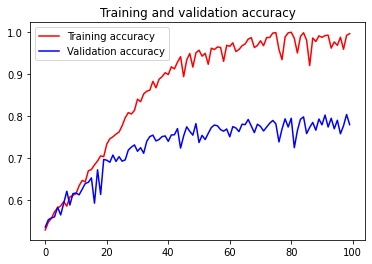

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [29]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [30]:
y_test_labels=[np.argmax(i) for i in y_test]
y_test_labels[:5]

[2, 2, 3, 3, 0]

In [31]:
X_test_labels=[np.argmax(i) for i in X_test]
X_test_labels[:5]

[56163, 72336, 60129, 64959, 111201]

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

In [35]:
class_labels=["mild","moderate","no","verymild"]
  

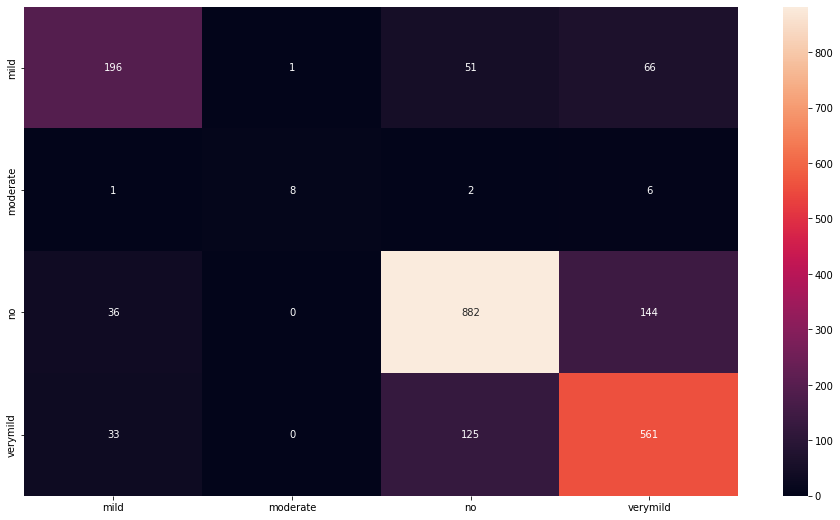

In [36]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,9))
cm=confusion_matrix(y_test_labels,ind)
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)

In [37]:
from sklearn.metrics import classification_report
cr=classification_report(y_test_labels,ind,target_names=class_labels)
print (cr)

              precision    recall  f1-score   support

        mild       0.74      0.62      0.68       314
    moderate       0.89      0.47      0.62        17
          no       0.83      0.83      0.83      1062
    verymild       0.72      0.78      0.75       719

    accuracy                           0.78      2112
   macro avg       0.79      0.68      0.72      2112
weighted avg       0.78      0.78      0.78      2112

